In [18]:
import numpy as np
import os 
import sys

from sklearn.decomposition import PCA
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.models import resnet18
from torchvision.transforms import Compose, ToTensor, Resize
from typing import Union
from tqdm import tqdm


In [19]:
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset

In [20]:
class QuantizedCamelyonDataset(Dataset):
    def __init__(self, root_dir, split):
        self.root_dir = root_dir
        self.split = split
        self.labels = torch.load(os.path.join(root_dir, split, 'labels.pt'))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        data = torch.load(os.path.join(self.root_dir, self.split, f'{index}.pt'))
        return torch.dequantize(data) / 255, self.labels[index]

In [21]:
def download_camelyon(root_dir):
    Camelyon17Dataset(root_dir=root_dir, download=True)

In [22]:
from typing import Tuple

from torch.utils.data import Dataset, random_split
from torch import Tensor
import torch


def split_dataset(dataset: Dataset, num_samples: int, random_seed: int = 42) -> Tuple[Dataset, Dataset]:
    # noinspection PyTypeChecker
    return random_split(dataset, [num_samples, len(dataset) - num_samples],
                        generator=torch.Generator().manual_seed(random_seed))

In [23]:
def camelyon(split='train', num_samples: Union[int, str] = 'all', quantized=True):
    cpath = 'data/camelyon17'
    if quantized:
        # if you've run quantize_camelyon()
        ds = QuantizedCamelyonDataset(root_dir=cpath, split=split)
    else:
        # otherwise
        splits = {'train': 'train',
                  'val': 'id_val',
                  'harmful': 'test',
                  'not_harmful': 'val',
                  'test': 'id_val'}
        split_mapped = splits[split]
        try:
            dataset = Camelyon17Dataset(root_dir=cpath, download=False)
        except FileNotFoundError:
            response = input('Camelyon17 dataset not found. Download? [y/n]: ')
            if response == 'y':
                path = input(f'Enter root directory for download or press '
                             f'Enter to use default [{cpath}]: ')
                if path == '':
                    path = cpath
                if not os.path.exists(p := os.path.realpath(path)):
                    raise NotADirectoryError(p)

                download_camelyon(path)
                dataset = Camelyon17Dataset(root_dir=cpath, download=False)
            else:
                print('Download Camelyon17 manually and update `camelyon17` in config.json')
                raise FileNotFoundError('Camelyon17 dataset not found.')
        ds = dataset.get_subset(split_mapped, transform=Compose([Resize((224, 224)), ToTensor()]))

        if split == 'val' or split == 'test':
            val, test = split_dataset(ds, random_seed=0, num_samples=int(len(ds) * 0.5))
            if split == 'val':
                ds = val
            else:
                ds = test

    if num_samples != 'all':
        assert isinstance(num_samples, int)
        ds, _ = split_dataset(ds, num_samples=num_samples, random_seed=0)

    return ds

In [24]:
def write(root_dir, data):
    index, data = data
    torch.save((255 * data[0]).type(torch.uint8), os.path.join(root_dir, f'{index}.pt'))
    return data[1].item()

In [28]:

def quantize_camelyon(root_dir='data/camelyon17_quantized'):
    os.makedirs(root_dir, exist_ok=True)
    for i, split in enumerate(('train', 'val', 'harmful', 'not_harmful', 'test')):
        print(f'Preprocessing ({split}) {i + 1}/5 ...')
        ds = camelyon(split, quantized=False)
        os.makedirs(os.path.join(root_dir, split), exist_ok=True)
        func = partial(write, os.path.join(root_dir, split))
        labels = [func(data) for data in enumerate(tqdm(ds, total=len(ds)))]
        torch.save(torch.tensor(labels), os.path.join(root_dir, split, 'labels.pt'))

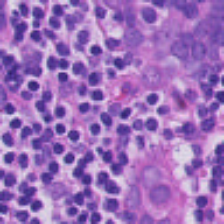

In [68]:
d = Camelyon17Dataset(root_dir='data/', download=False)
ds = d.get_subset(split='test', transform=Resize((224,224)))
ds[0][0]

## Camelyon17 Training

We proceed in steps: 
- Split the Camelyon17 dataset into different splits corresponding to different iid/ood settings.
- Train and validate on the train/id_val split, while reporting OOD-performance on the test set to assess some model degradation.
- Extract features with the newly trained resnet and ship it out.




In [122]:
learning_rate=5e-5
batch_size=64
epochs=100

In [133]:
import multiprocessing
from torchvision.models import resnet18, ResNet18_Weights, ResNet
from torch.utils.data import DataLoader

In [135]:
dataset = Camelyon17Dataset(root_dir='data/', download=False)
splits = ['train', 'id_val', 'val', 'test']
datasets = {}
dataloaders = {}
for split in splits:
    datasets[split] = dataset.get_subset(split=split, transform=ToTensor())
    dataloaders[split] = torch.utils.data.DataLoader(datasets[split], batch_size=batch_size, num_workers=multiprocessing.cpu_count())

In [139]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 1)

In [140]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.cuda()

In [150]:
def train(model, loader, criterion, optimizer):
    # Train
    model.train()
    for batch_idx, (imgs, labels, _) in enumerate(tqdm(loader)):
        imgs, labels = imgs.cuda(), labels.cuda().float()
        output = model(imgs).squeeze(-1)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
def evaluate(model, loader):
    # IID eval
    model.eval()
    count = 0
    acc = 0
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = F.sigmoid(model(imgs))
            preds = torch.round(output)
            acc += torch.sum(preds == labels)
            count += len(labels)
            
    acc = (acc/count).item()
    return acc    

In [151]:
patience = 0
best = 0
best_state_dict = None
model = model.cuda()
for epoch in range(epochs):
    print('Running epoch {}...'.format(epoch + 1))
    train(model, dataloaders['train'], criterion, optimizer)
    iid_acc = evaluate(model, dataloaders['id_val'])
    ood_acc = evaluate(model, dataloaders['val'])
    if ood_acc > best:
        best = ood_acc
        best_state_dict = model.state_dict().copy()
        patience = 0
    else:
        patience += 1
    print('iid: {},\tood: {}'.format(iid_acc, ood_acc))
    if patience > 5:
        print('Max patience reached! Returning...')
        break    
        

Running epoch 1...


 54%|█████▍    | 2542/4726 [00:47<00:40, 53.90it/s]


KeyboardInterrupt: 